# Quantum Computing Experimentation with Amazon Braket
### Chapter 4 - Writing your first Amazon Braket Code Sample
<p> © 2021, 2022, 2023 Packt Publishing
<p> Written by Alex Khan


#### 1. Find Active Devices
The following code retrieves active devices in Amazon Braket

More information can be found at https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.aws.aws_device.html

In [1]:
from braket.aws import AwsDevice

In [4]:
device_list=AwsDevice.get_devices(statuses=['ONLINE'])

In [5]:
print(device_list)

[Device('name': Aquila, 'arn': arn:aws:braket:us-east-1::device/qpu/quera/Aquila), Device('name': Aspen-M-3, 'arn': arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3), Device('name': Borealis, 'arn': arn:aws:braket:us-east-1::device/qpu/xanadu/Borealis), Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice), Device('name': Lucy, 'arn': arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy), Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1), Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1), Device('name': dm1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/dm1)]


In [6]:
device_name_list=[]
for device in device_list:
    device_name_list.append(device.name)
print('Valid device names: ',device_name_list)

Valid device names:  ['Aquila', 'Aspen-M-3', 'Borealis', 'IonQ Device', 'Lucy', 'SV1', 'TN1', 'dm1']


In [7]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [8]:
available_devices()

['Aquila', 'Aspen-M-3', 'Borealis', 'IonQ Device', 'Lucy', 'SV1', 'TN1', 'dm1']

#### 2. Assign Device

The typical method to assign a **device** is to use the full **arn** as shown below

In [9]:
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")

In [10]:
print(rigetti)

Device('name': Aspen-M-3, 'arn': arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3)


Rather than providing the full **arn**, this function only requires the device **name** to set the **device**

device=AwsDevice.get_devices(names=[Name])

for example if using the device sv1

In [11]:
sv1=AwsDevice.get_devices(names='SV1')
print(sv1)

[Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)]


Note that the device name is case sensitive

The function **set_device(Name)** will be used from now on to set the **device** using only the **Name** of the device and the full **arn** will not be needed.

In [12]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [13]:
device=set_device('svi')

No device found
use name from list ['Aquila', 'Aspen-M-3', 'Borealis', 'IonQ Device', 'Lucy', 'SV1', 'TN1', 'dm1']


#### 3. Cost Estimation
The following code shows how to estimate the cost of the different devices

In [14]:
def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Aspen-M-3','IonQ Device', 'Aquila', 'Lucy']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [15]:
device_name='Aquila'
device=set_device(device_name)
estimate_cost(device)

Device('name': Aquila, 'arn': arn:aws:braket:us-east-1::device/qpu/quera/Aquila)
device cost per  shot : $ 0.01
total cost for 1000 shots is $10.30


Since the device cost is depended on the number of shots, which should be varied based on the number of qubits being measured. The following function can help in more accurately estimating the cost based on the number of measured qubits.

In [17]:
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)


In [18]:
device=set_device('Aquila')
estimate_cost_measured_qubits(device, 5)

Device('name': Aquila, 'arn': arn:aws:braket:us-east-1::device/qpu/quera/Aquila)
max shots: 1000
for 5 measured qubits the number of shots recommended: 800
device cost per  shot : $ 0.01
total cost for 800 shots is $8.30


In this next block we will make estimates for each of the devices based on the maximum allowed shots

In [19]:
for Name in ['SV1','TN1','dm1']:
    device=set_device(Name)
    qubit_count = device.properties.paradigm.qubitCount
    estimate_cost_measured_qubits(device, qubit_count)
    print('---')

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
max shots: 100000
for 34 measured qubits the maximum allowed shots: 100,000
simulator cost per  minute : $ 0.075
total cost cannot be estimated
---
Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
max shots: 1000
for 50 measured qubits the maximum allowed shots: 1,000
simulator cost per  minute : $ 0.275
total cost cannot be estimated
---
Device('name': dm1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/dm1)
max shots: 100000
for 17 measured qubits the maximum allowed shots: 100,000
simulator cost per  minute : $ 0.075
total cost cannot be estimated
---


In [20]:
for Name in ['Aspen-M-3','IonQ Device','Aquila','Lucy']:
    device=set_device(Name)
    if Name=='Aspen-M-3':
        qubit_count=80
    if Name=='Aquila':
        qubit_count=256
    if Name=='Lucy':
        qubit_count=8
    if Name=='Borealis':
        qubit_count=216
    elif Name=='IonQ Device':
        qubit_count=11
    estimate_cost_measured_qubits(device, qubit_count)
    print('---')

Device('name': Aspen-M-3, 'arn': arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3)
max shots: 100000
for 80 measured qubits the maximum allowed shots: 100,000
device cost per  shot : $ 0.00035
total cost for 100000 shots is $35.30
---
Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
max shots: 10000
for 11 measured qubits the maximum allowed shots: 10,000
device cost per  shot : $ 0.01
total cost for 10000 shots is $100.30
---
Device('name': Aquila, 'arn': arn:aws:braket:us-east-1::device/qpu/quera/Aquila)
max shots: 1000
for 256 measured qubits the maximum allowed shots: 1,000
device cost per  shot : $ 0.01
total cost for 1000 shots is $10.30
---
Device('name': Lucy, 'arn': arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy)
max shots: 10000
for 8 measured qubits the number of shots recommended: 6,400
device cost per  shot : $ 0.00035
total cost for 6400 shots is $2.54
---


Since we could not estimate the cost of the simulators in advance, it is possible to get the cost after execution using the function results.additional_metadata.simulatorMetadata.executionDuration

We will come back to this after we have created a simple circuit and visualized that circuit.

#### 4. Creating a simple quantum circuit

In [ ]:
#!pip install matplotlib

In [21]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
%matplotlib inline

Now we build the circuit using **Circuit**

In [22]:
bits = Circuit().i(0).x(1)

In [23]:
print(bits)

T  : |0|
        
q0 : -I-
        
q1 : -X-

T  : |0|


Counter({'01': 1000})


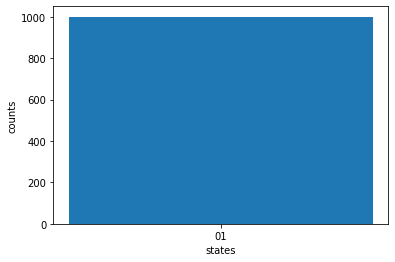

In [24]:
device = LocalSimulator()
result = device.run(bits, shots=1000).result()
counts = result.measurement_counts
print(counts)
plt.bar(counts.keys(), counts.values());
plt.xlabel('states');
plt.ylabel('counts');

In [25]:
def build_binary_circ(N):
    binary_num=bin(N)[2:]
    num_qubits=len(binary_num)
    print(binary_num)
    binary_circuit=Circuit()
    position=0
    for bit in binary_num:
        #print(bit)
        if bit=='0':
            binary_circuit.i(position)
        else:
            binary_circuit.x(position)
        position+=1
    return(binary_circuit)   

110
T  : |0|
        
q0 : -X-
        
q1 : -X-
        
q2 : -I-

T  : |0|
Counter({'110': 1000})


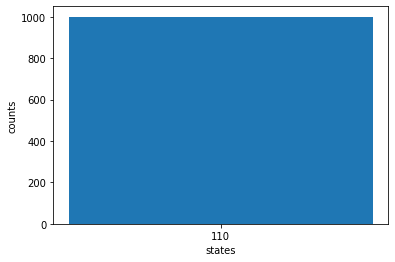

In [26]:
binary_circuit=build_binary_circ(6)
print(binary_circuit)
device = LocalSimulator()
result = device.run(binary_circuit, shots=1000).result()
counts = result.measurement_counts
print(counts)
plt.bar(counts.keys(), counts.values());
plt.xlabel('states');
plt.ylabel('counts');

#### 5. Running a circuit on a simulator device

In [33]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[bucket_name]" # the name of the bucket
my_prefix = "[folder_name]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [34]:
def run_circuit(device, circuit, shots, s3_folder):
    import matplotlib.pyplot as plt
    %matplotlib inline
    result = device.run(circuit, shots=shots, s3_destination_folder=s3_folder).result()
    counts = result.measurement_counts
    print(counts)
    plt.bar(counts.keys(), counts.values());
    plt.xlabel('states');
    plt.ylabel('counts');
    return(result)

In [35]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

Lets use this function to get the cost for a sample run on SV1

In [36]:
N=2896
qubit_count=len(bin(N))-2
print('qubit count: ', qubit_count)
binary_circuit=build_binary_circ(N)
print(binary_circuit)

qubit count:  12
101101010000
T   : |0|
         
q0  : -X-
         
q1  : -I-
         
q2  : -X-
         
q3  : -X-
         
q4  : -I-
         
q5  : -X-
         
q6  : -I-
         
q7  : -X-
         
q8  : -I-
         
q9  : -I-
         
q10 : -I-
         
q11 : -I-

T   : |0|


In [37]:
device=set_device('SV1')
estimate_cost_measured_qubits(device, qubit_count)

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
max shots: 100000
for 12 measured qubits the maximum allowed shots: 100,000
simulator cost per  minute : $ 0.075
total cost cannot be estimated


Counter({'101101010000': 10})


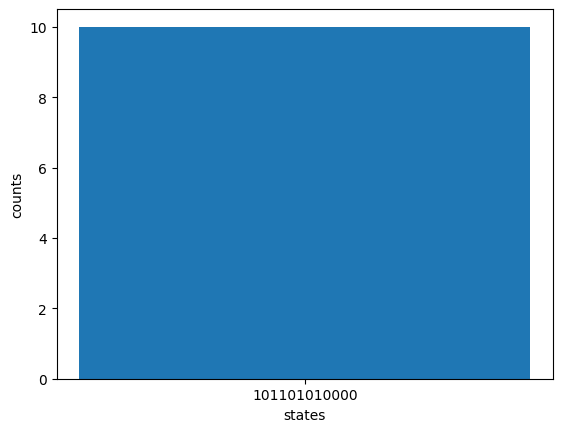

In [38]:
result=run_circuit(device, binary_circuit, 10, s3_folder)

In [39]:
actual_simulator_cost(device, result)

simulator cost per  minute : $ 0.075
total execution time:  3 ms
total cost estimated: $ 3.7500000000000005e-06


### D-Wave test

In [41]:
import numpy as np
from numpy.random import rand

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
#from minorminer import find_embedding
#import networkx as nx
#import dwave.inspector

In [55]:
# Random matrix
dim=3
Q=np.zeros((dim,dim))
#Q =  2*rand(dim,dim) - 1
#Q = (Q+Q.T)/2
for i in range(dim):
    for j in range(dim):
        if i==j:
            Q[i,j] = np.abs(rand())/2
        elif i<j:
            Q[i,j] = 2*rand()-1

print(Q)

[[ 0.44462793 -0.55647889  0.77689622]
 [ 0.          0.08383466 -0.43679893]
 [ 0.          0.          0.14141268]]


In [56]:
# convert matrix into a QUBO with linear=biases and quadratic=couplings terms
linear={('a'+str(k), 'a'+str(k)):Q[k][k] for k in range(dim)}

quadratic={('a'+str(i), 'a'+str(j)):Q[i][j] for i in range(dim) for j in range(dim) if i<j}

QDwave = dict(linear)
QDwave.update(quadratic)

print(QDwave)

{('a0', 'a0'): 0.4446279314645751, ('a1', 'a1'): 0.08383465518476618, ('a2', 'a2'): 0.1414126808211072, ('a0', 'a1'): -0.5564788850285554, ('a0', 'a2'): 0.7768962173499079, ('a1', 'a2'): -0.43679892680061116}


In [59]:
numruns = 10
sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(QDwave, num_reads=numruns)
print(response)


  a0 a1 a2    energy num_oc. chain_.
0  0  1  1 -0.211552      10     0.0
['BINARY', 1 rows, 10 samples, 3 variables]
